In [1]:
import timeit
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tabulate import tabulate
from src import plot
from src import segnet
from src.tiramisu import tiramisu
from src.tiramisu import aleatoric_tiramisu
from src.tiramisu import epi_approx_tiramisu
from src import wrappers
%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import random
random.seed(1)
np.random.seed(1)

In [3]:
# the size to crop images to
intput_size = (352, 480, 3)

# Data

In [4]:
X = np.random.randint(low=0, high=256, size=(1, *intput_size))

# Build Models

In [5]:
def new_keras_session(build_model):
    """A decorator to clear the Keras session and build a model."""
    def _new_keras_session(*args, **kwargs):
        # clear the Keras session
        K.clear_session()
        # call the method to build a Keras model
        return build_model(*args, **kwargs)
    # reset the name of the method to the original name
    _new_keras_session.__name__ = build_model.__name__

    return _new_keras_session

In [6]:
@new_keras_session
def build_segnet():
    """Return a trained SegNet model."""
    return segnet.segnet(intput_size, 11)

In [7]:
@new_keras_session
def build_baysiean_segnet():
    """Return a trained Bayesian SegNet model."""
    model = segnet.segnet(intput_size, 11, dropout_rate=0.5)
    return wrappers.MonteCarlo(model, 50)

In [8]:
@new_keras_session
def build_tiramisu_45():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu(intput_size, 11,
        growth_rate=12,
        layer_sizes=[3, 3, 3, 3, 3],
        bottleneck_size=3,
    )

In [9]:
@new_keras_session
def build_tiramisu_56():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu(intput_size, 11,
        growth_rate=12,
        layer_sizes=[4, 4, 4, 4, 4],
        bottleneck_size=4,
    )

In [10]:
@new_keras_session
def build_tiramisu_67():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu(intput_size, 11,
        growth_rate=16,
        layer_sizes=[5, 5, 5, 5, 5],
        bottleneck_size=5,
    )

In [11]:
@new_keras_session
def build_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu(intput_size, 11)

In [12]:
@new_keras_session
def build_aleatoric_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return aleatoric_tiramisu.aleatoric_tiramisu(intput_size, 11)

In [13]:
@new_keras_session
def build_epistemic_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    model = tiramisu.tiramisu(intput_size, 11, mc_dropout=True)
    return wrappers.MonteCarlo(model, 50)

In [14]:
@new_keras_session
def build_epistemic_approx_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return epi_approx_tiramisu.epi_approx_tiramisu(intput_size, 11)

# Time Tests

In [15]:
def time_test(model, repeat: int=7) -> pd.Series:
    """
    Run a prediction time test for the given model.

    Args:
        repeat: the number of trials to generate mean and std time

    Returns:
        a series with the:
        - mean of the repeat trials
        - standard deviation of the repeat trials

    """
    # run time trials for the number of repetitions + 1
    times = timeit.repeat(lambda: model.predict(X), repeat=repeat + 1, number=1)
    # throw out the first time that usually is anomalous
    times = pd.Series(times[1:])
    # return a series with the data
    return pd.Series([times.mean(), times.std()], index=['mean', 'std'])

In [16]:
# generate a dataframe of results for each model in ms
results = pd.DataFrame({
    'SegNet': time_test(build_segnet()),
    'Bayesian-SegNet': time_test(build_baysiean_segnet()),
    'Tiramisu-45': time_test(build_tiramisu_45()),
    'Tiramisu-56': time_test(build_tiramisu_56()),
    'Tiramisu-67': time_test(build_tiramisu_67()),
    'Tiramisu-103': time_test(build_tiramisu_103()),
    'Tiramisu-103 (Aleatoric)': time_test(build_aleatoric_tiramisu_103()),
    'Tiramisu-103 (Epistemic)': time_test(build_epistemic_tiramisu_103()),
    'Tiramisu-103 (Epistemic Approximation)': time_test(build_epistemic_approx_tiramisu_103()),
}).T.sort_values('mean').T * 1000
results.T.to_csv('models/wall-clock-time-analysis.csv')

/users/PMIU0138/miu0212/neural-semantic-segmentation/src/tiramisu/aleatoric_tiramisu.py:86: UserWarning: Output "sigma" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "sigma" during training.
  metrics={'softmax': [build_categorical_accuracy(weights=class_weights)]},
/users/PMIU0138/miu0212/neural-semantic-segmentation/src/tiramisu/epi_approx_tiramisu.py:72: UserWarning: Output "entropy" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "entropy" during training.
  metrics={'tiramisu': [build_categorical_accuracy(weights=class_weights)]},


In [17]:
results.T

,mean,std
SegNet,53.691216,0.331099
Tiramisu-45,55.461053,1.714660
Tiramisu-56,76.196948,0.800425
Tiramisu-67,117.199655,1.196372
Tiramisu-103,119.834548,0.463746
Tiramisu-103 (Epistemic Approximation),121.677694,1.838765
Tiramisu-103 (Aleatoric),137.432888,1.240590
Bayesian-SegNet,3460.010220,15.644349
Tiramisu-103 (Epistemic),7326.041287,48.107051


In [18]:
print(tabulate(results.T, tablefmt='pipe', headers=('Model', 'Mean (ms)', 'SD. (ms)')))

| Model                                  |   Mean (ms) |   SD. (ms) |
|:---------------------------------------|------------:|-----------:|
| SegNet                                 |     53.6912 |   0.331099 |
| Tiramisu-45                            |     55.4611 |   1.71466  |
| Tiramisu-56                            |     76.1969 |   0.800425 |
| Tiramisu-67                            |    117.2    |   1.19637  |
| Tiramisu-103                           |    119.835  |   0.463746 |
| Tiramisu-103 (Epistemic Approximation) |    121.678  |   1.83877  |
| Tiramisu-103 (Aleatoric)               |    137.433  |   1.24059  |
| Bayesian-SegNet                        |   3460.01   |  15.6443   |
| Tiramisu-103 (Epistemic)               |   7326.04   |  48.1071   |


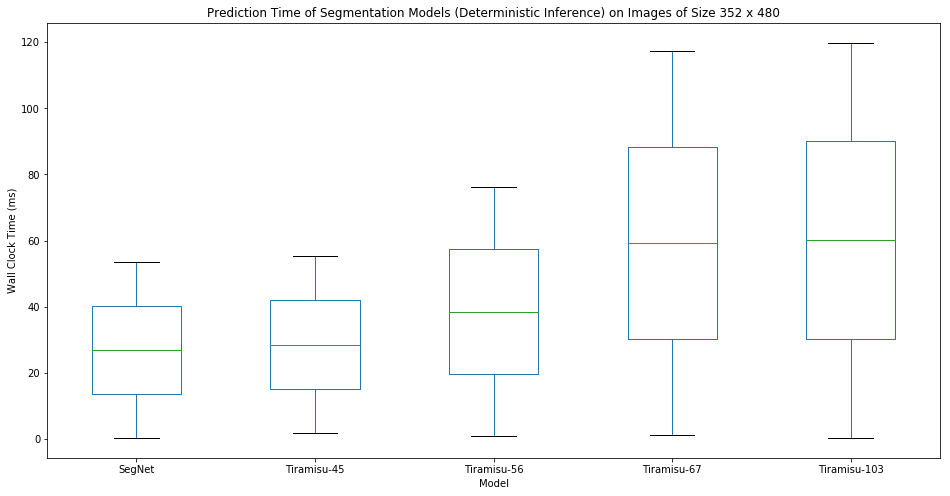

In [19]:
models = ['SegNet', 'Tiramisu-45', 'Tiramisu-56', 'Tiramisu-67', 'Tiramisu-103']
ax = results[models].plot.box(figsize=(16, 8))
ax.set_xlabel('Model')
ax.set_ylabel('Wall Clock Time (ms)')
ax.set_title('Prediction Time of Segmentation Models (Deterministic Inference) on Images of Size 352 x 480')
plt.savefig('img/inference-time.png', transparent=True, bbox_inches='tight')

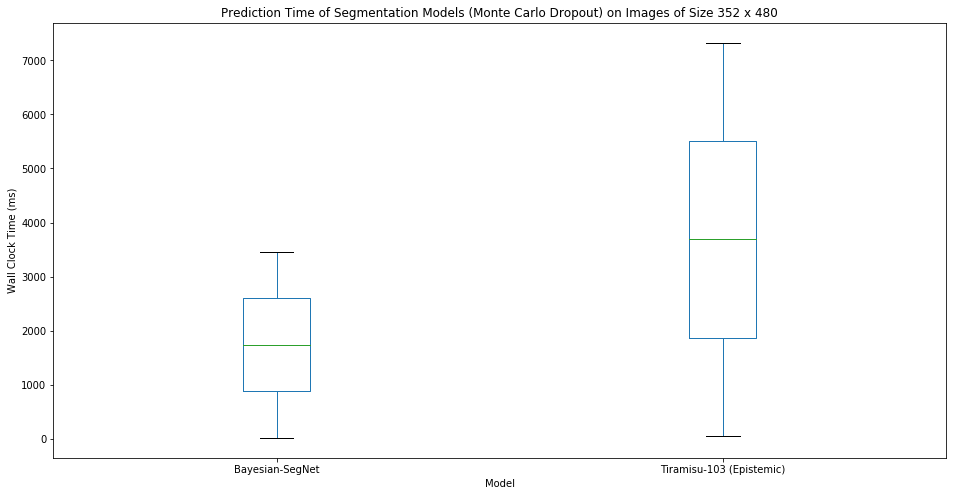

In [20]:
bayesian = ['Bayesian-SegNet', 'Tiramisu-103 (Epistemic)']
ax = results[bayesian].plot.box(figsize=(16, 8))
ax.set_xlabel('Model')
ax.set_ylabel('Wall Clock Time (ms)')
ax.set_title('Prediction Time of Segmentation Models (Monte Carlo Dropout) on Images of Size 352 x 480')
plt.savefig('img/inference-time-mc-dropout.png', transparent=True, bbox_inches='tight')